In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import fetch_openml

In [3]:
mnist = fetch_openml("mnist_784", version=1, as_frame=False)
type(mnist) # Аналог словаря

sklearn.utils.Bunch

In [4]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
X, y = mnist.data, mnist.target
X.shape, y.shape

((70000, 784), (70000,))

(-0.5, 27.5, 27.5, -0.5)

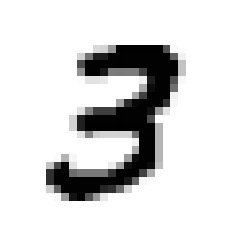

In [6]:
plt.imshow(X[7].reshape(28, 28), cmap="binary")
plt.axis("off")

In [7]:
y[7]

'3'

In [8]:
y = y.astype(np.int32) # т.к. изначально строка

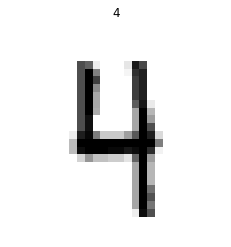

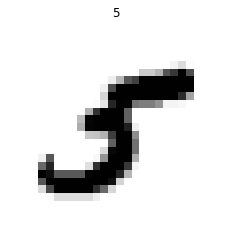

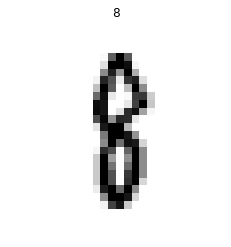

In [9]:
for i in range(3):
    idx = np.random.randint(69999)
    plt.imshow(X[idx].reshape((28,28)), cmap='binary')
    plt.axis("off")
    plt.title(f"{y[idx]}")
    plt.show()

In [10]:
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:] # Разбиваем на обучающее и тестовое множество

# Бинарный классификатор

In [11]:
y_train_7 = (y_train == 7)
y_test_7 = (y_test == 7)

In [12]:
from sklearn.linear_model import SGDClassifier

In [13]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_7)

SGDClassifier(random_state=42)

In [14]:
sgd_clf.predict([X_train[15]])

array([ True])

In [15]:
y[15]

7

In [16]:
from sklearn.metrics import accuracy_score

In [17]:
pred = sgd_clf.predict(X_train)
accuracy_score(y_train_7, pred)

0.9856833333333334

In [18]:
from sklearn.model_selection import StratifiedKFold

In [19]:
# Собственный KFold валидатор
strat_k_fold = StratifiedKFold(5)
for tr_idx, tst_idx in strat_k_fold.split(X_train, y_train_7):
    sgd_clf = SGDClassifier(random_state=42)
    X_train_folds = X_train[tr_idx]
    y_train_folds = y_train_7[tr_idx]
    X_val_folds = X_train[tst_idx]
    y_val_folds = y_train_7[tst_idx]
    sgd_clf.fit(X_train_folds, y_train_folds)
    pred = sgd_clf.predict(X_val_folds)
    print("Built in function accuracy: {}".format(accuracy_score(y_val_folds, pred)))

Built in function accuracy: 0.9803333333333333
Built in function accuracy: 0.9825
Built in function accuracy: 0.9733333333333334
Built in function accuracy: 0.97725
Built in function accuracy: 0.9763333333333334


In [20]:
from sklearn.model_selection import cross_val_score

In [21]:
cross_val_score(SGDClassifier(random_state=42), X_train, y_train_7, scoring="accuracy", cv=5)

array([0.98033333, 0.9825    , 0.97333333, 0.97725   , 0.97633333])

In [22]:
zeros_pred = np.zeros(y_train_7.shape[0])
accuracy_score(y_train_7, zeros_pred)
# Из результата видно, что accuracy - не лучшая оценка для проверки модели.

0.8955833333333333

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_predict

In [24]:
pred = cross_val_predict(SGDClassifier(random_state=42), X_train, y_train_7, cv=5)
confusion_matrix(y_train_7, pred, labels=[0,1])

array([[53180,   555],
       [  768,  5497]])

In [25]:
from sklearn.metrics import precision_score, recall_score

In [26]:
precision_score(y_train_7, pred) # Классификатор определяет 7-ку с 90% вероятностью
# Отображает точность прогнозов как отношение TP / (TP + FP).
# Точность важна в тех случаях, когда важно исключить ошибки ценой количества
# (Алгоритм выдаёт только правильные результаты, жертуя их количеством)

0.9082947785855915

In [27]:
recall_score(y_train_7, pred) # Классификатор определяет 87% 7-ок 
# Отображает полноту прогнозов как отношение TP / (TP + FN)
# Или же способность модели количественно захватить больше правильных, жертвуя
# точностью


0.877414205905826

In [28]:
from sklearn.metrics import f1_score

In [29]:
f1_score(y_train_7, pred) # Среднее гармоническое точности и полноты
#Метрика F1 придаёт низким значениям больший вес
#Поэтому оценка будет высока, когда и точность, и общность высоки одновременно

0.8925874807177073

In [30]:
y_scores = sgd_clf.decision_function([X_train[15]]) # выдаёт сумму очков от модели
y_scores

array([5004.34292937])

In [31]:
threshold = 0
some_dig_pred = bool(y_scores > threshold)
some_dig_pred, y_train_7[15]
#Устанавливаем пороговое значение, по которому классификатор будет определять
#принадлежность к классу

(True, True)

In [32]:
y_scores = sgd_clf.decision_function([X_train[0]])
y_scores

array([-13343.60257777])

In [33]:
some_dig_pred = bool(y_scores > threshold)
some_dig_pred, y_train_7[0]

(False, False)

In [34]:
y_scores = cross_val_predict(SGDClassifier(random_state=42), X_train, y_train_7,
                             method="decision_function", cv=3)
# Изменяем метод с предиктов на сумму очков

In [35]:
from sklearn.metrics import precision_recall_curve

In [36]:
precision, recall, threshold = precision_recall_curve(y_train_7, y_scores)

In [37]:
def plot_decision_recall_threshold(precisions, recalls, thresholds, idx_prec = None):
    """Функция вычерчивает график точности и полноты в зависимости от порога"""
    plt.plot(thresholds, precisions[:-1], label="Prec")
    plt.plot(thresholds, recalls[:-1], label="Rec")
    if idx_prec is not None:
        plt.scatter((thresholds[idx_prec], thresholds[idx_prec]), (precisions[idx_prec], recalls[idx_prec]))
    plt.title("График зависимостей точности, полноты от порога")
    plt.legend()


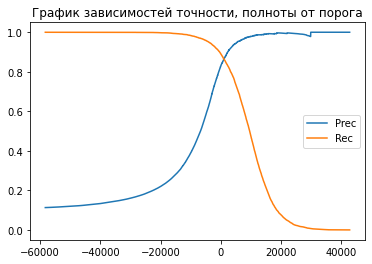

In [38]:
plot_decision_recall_threshold(precision, recall, threshold)

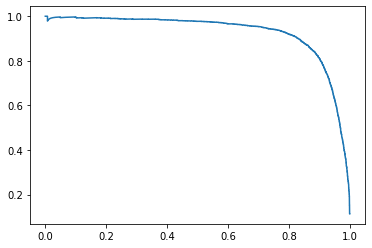

In [39]:
plt.plot(recall, precision) # График зависимости точности от полноты

In [40]:
idx_prec = np.argmax(precision >= 0.9) # Первый индекс в котором точность приблизительно равно 90%
print(f"{idx_prec}")
thres_90 = threshold[idx_prec] # Найдём пороговое значение, для такой точности
print("Пороговое значение для заданной точности: {}".format(thres_90))
print("Значение точности: {}".format(precision[idx_prec]))
print("Значение полноты: {}".format(recall[idx_prec]))

49589
Пороговое значение для заданной точности: 2288.724768166237
Значение точности: 0.9000864304235091
Значение полноты: 0.8311252992817239


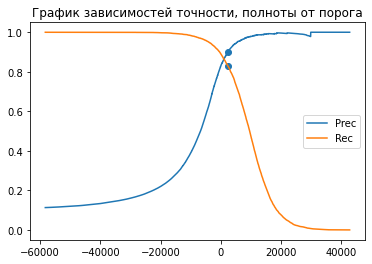

In [41]:
plot_decision_recall_threshold(precision, recall, threshold, idx_prec)

In [42]:
y_train_pred_90 = (y_scores >= thres_90).astype('bool') # Предикты на основе порога
accuracy_score(y_train_7, y_train_pred_90)

0.9727333333333333

In [43]:
from sklearn.metrics import roc_curve

In [44]:
fpr, tpr, threshold = roc_curve(y_train_7, y_scores)

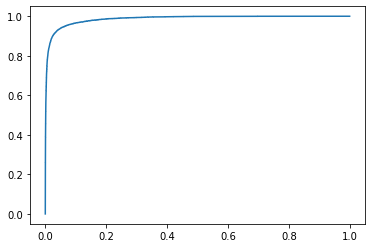

In [45]:
plt.plot(fpr, tpr)

In [46]:
from sklearn.metrics import roc_auc_score

In [47]:
roc_auc_score(y_train_7, y_scores) # Площадь под кривой (выше), чем ближе к 1, тем лучше

0.986670497551944

In [48]:
from sklearn.ensemble import RandomForestClassifier

In [49]:
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(X_train, y_train_7)
accuracy_score(y_train_7, rnd_clf.predict(X_train))

1.0

In [50]:
forest_clf = RandomForestClassifier(random_state=42)
rnd_prob = cross_val_predict(forest_clf, X_train, y_train_7, cv=3, method="predict_proba")
rnd_prob[:5]

array([[0.98, 0.02],
       [1.  , 0.  ],
       [0.89, 0.11],
       [1.  , 0.  ],
       [0.95, 0.05]])

In [51]:
fpr_frst, tpr_frst, thres = roc_curve(y_train_7, rnd_prob[:, 1])

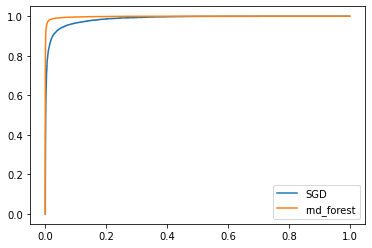

In [52]:
plt.plot(fpr, tpr, label="SGD")
plt.plot(fpr_frst, tpr_frst, label = "rnd_forest")
plt.legend()

In [53]:
roc_auc_score(y_train_7, rnd_prob[:,1])

0.9982747530426836

In [54]:
y_train_pred_forest = cross_val_predict(RandomForestClassifier(random_state=42), X_train, y_train_7, cv=3)
precision_score(y_train_7, y_train_pred_forest)

0.9867364746945899

In [55]:
recall_score(y_train_7, y_train_pred_forest)

0.9024740622505986